<a href="https://colab.research.google.com/github/jakedorman64/internship/blob/main/regression_with_haiku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Using Haiku
Guide [here](https://coderzcolumn.com/tutorials/artificial-intelligence/haiku-guide-to-create-multi-layer-perceptrons-using-jax).

In [1]:
!pip install git+https://github.com/deepmind/dm-haiku

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-tf70sc78
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-tf70sc78
  Resolved https://github.com/deepmind/dm-haiku to commit 4b0401225221c2fba092903edfab15fc6e102642
  Preparing metadata (setup.py) ... done
  Created wheel for dm-haiku: filename=dm_haiku-0.0.10.dev0-py3-none-any.whl size=360275 sha256=0981e87a3b79e5fe0a3a9c7903de69de91d2becbc6c72954d254847890edc61f
  Stored in directory: /tmp/pip-ephem-wheel-cache-xkuej377/wheels/b1/df/f1/a357fa8f00c36052bdae1e1fd363650c0bd1e8c3959487b6fb
Successfully built dm-haiku


In [398]:
import haiku as hk
import jax
import matplotlib.pyplot as plt
import jax.numpy as jnp
from sklearn.model_selection import train_test_split
import time
from jax.numpy import pi, sin, cos
from jax import value_and_grad, jit, vmap, grad, random

In [417]:
# Create our random keys
key, subkey = random.split(random.PRNGKey(int(time.time())))
learning_rate = 0.01
epochs = 10000

# Generate inputs and targets
inputs = random.uniform(key, minval=0, maxval=10, shape=(1000,))
targets = 2 * inputs + 2* sin(inputs) + 0.5 * random.normal(subkey, shape=(1000,))

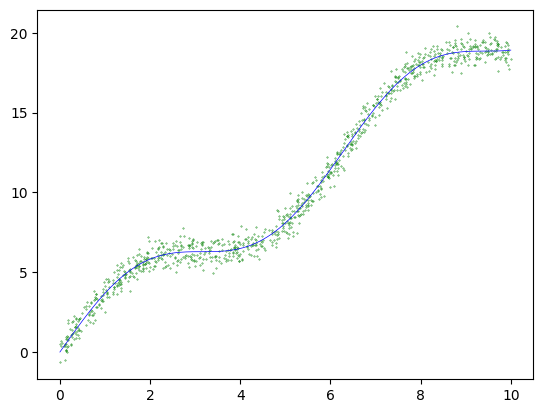

In [418]:
# Graph targets against actual curve.
plt.scatter(inputs, targets, s=0.1, color='green')
fine_inputs = jnp.reshape(jnp.linspace(0, 10, 1000), (1000, 1))
plt.plot(fine_inputs, 2*(fine_inputs + sin(fine_inputs)), lw=0.5, color='blue')

In [419]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.33, random_state=42)

# Data needs to be in this format to go into the model.
x_train = x_train.reshape(len(x_train),1)
x_test = x_test.reshape(len(x_test),1)

In [435]:
# Define a feed forward multi layer perceptron with layers of size 1, 5, 10, 5, 1.
def FeedForward(x):
  mlp = hk.nets.MLP(output_sizes=[1000, 1000, 200, 1], activation=jax.nn.sigmoid)
  return mlp(x)

# This transforms our model from a class based module into a function based one.
model = hk.transform(FeedForward)

In [436]:
rng = jax.random.PRNGKey(12)

params = model.init(rng, x_train[:1])

print("Weights Type : {}\n".format(type(params)))

for layer_name, weights in params.items():
    print(layer_name)
    print("Weights : {}, Biases : {}\n".format(params[layer_name]["w"].shape,params[layer_name]["b"].shape))

Weights Type : <class 'dict'>

mlp/~/linear_0
Weights : (1, 1000), Biases : (1000,)

mlp/~/linear_1
Weights : (1000, 1000), Biases : (1000,)

mlp/~/linear_2
Weights : (1000, 200), Biases : (200,)

mlp/~/linear_3
Weights : (200, 1), Biases : (1,)



In [437]:
#These are our initial predictions with no training.
preds = model.apply(params, rng, x_train)

In [438]:
def MeanSquaredErrorLoss(weights, input_data, actual):
    preds = model.apply(weights, rng, input_data)

    # This removes the fact that it is an array of arrays.
    preds = preds.squeeze()
    return jnp.power(actual - preds, 2).mean()

In [439]:
def UpdateWeights(weights, gradients):
    return weights - learning_rate * gradients

In [440]:
for i in range(1, epochs+1):
    loss, param_grads = value_and_grad(MeanSquaredErrorLoss)(params, x_train, y_train)
    params = jax.tree_map(UpdateWeights, params, param_grads)

    if i%100 == 0:
        print("MSE : {:.2f}".format(loss))


MSE : 14.62
MSE : 7.43
MSE : 4.40
MSE : 2.89
MSE : 2.01
MSE : 1.47
MSE : 1.15
MSE : 0.98
MSE : 0.90
MSE : 0.83
MSE : 0.76
MSE : 0.69
MSE : 0.63
MSE : 0.57
MSE : 0.52
MSE : 0.47
MSE : 0.43
MSE : 0.40
MSE : 0.38
MSE : 0.36
MSE : 0.34
MSE : 0.33
MSE : 0.32
MSE : 0.31
MSE : 0.31
MSE : 0.30
MSE : 0.30
MSE : 0.29
MSE : 0.29
MSE : 0.29
MSE : 0.29
MSE : 0.29
MSE : 0.28
MSE : 0.28
MSE : 0.28
MSE : 0.28
MSE : 0.28
MSE : 0.28
MSE : 0.28
MSE : 0.28
MSE : 0.27
MSE : 0.27
MSE : 0.27
MSE : 0.27


KeyboardInterrupt: ignored

In [441]:
# Testing error:
print(MeanSquaredErrorLoss(params, x_test, y_test))

0.2696684


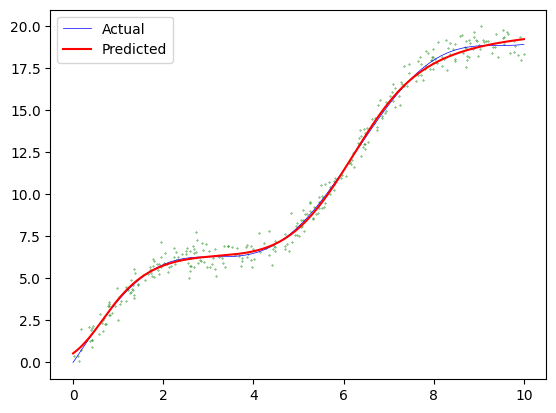

In [442]:
# Graph our prediction against the actual curve and the testing data
plt.scatter(x_test, y_test, s=0.1, color='green')
fine_inputs = jnp.reshape(jnp.linspace(0, 10, 1000), (1000, 1))
plt.plot(fine_inputs, 2* fine_inputs + 2 * sin(fine_inputs), lw=0.5, color='blue', label="Actual")
plt.plot(fine_inputs, model.apply(params, rng, fine_inputs), color='red', label="Predicted")
plt.legend()